# Exploring & Visualizing Job Listing Data using NLP Methods

This notebook demonstrates a the use of natural language processing methods to analyze text data. Specifically, we consider the titles of job listings and how we can extract meaning from them. Earlier, we looked at job listings in aggregate, but did not explore processing the actual text using advanced methods. Additionally, we looked at several machine learning models to classify posts into categories. We explored both binary classification and multi-class problems. We also assessed multiple algorithms, including Logistic Regression and Naive Bayes classifiers.

Here, we take a step back to look at the data _before_ we apply classification models. This will give us a sense of whether there is any inherent separation or difference within the data and help us understand whether our dataset is suited for machine learning. To do so, we will consider two situations:

1. Binary classification (gig vs. non-gig roles) 
2. Multi-label classification (nursing, delivery, service, etc)

The primary method employed here is Latent Semantic Analysis (LSA)

## Latent Semantic Analysis

Latent semantic analysis (LSA) is a natural language processing technique which analyzes relationships between a set of documents and the terms they contain. This is done by producing a set of concepts related to the documents and terms. LSA assumes that words that are close in meaning will occur in similar pieces of text.

Our existing pipeline cleans, tokenizes, and vectorizes text data. These representations or embeddings, mathematically represent our job title data from a dataset of job listings. Ultimately, we hope these embeddings can be classified in a manner which shows a clear separation or difference between multiple groups, or job categories.

We have previously applied a Bag of Words model to represent the frequency of terms in our dataset. It would be helpful to vizualize if this model representation shows any grouping or clustering of job titles which are similar. To do so, we apply LSA with two components. LSA is similar to PCA, but applied to text. We reduce the components of our data to two principle components, and visualize whether any clustering & separation is apparent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

### Processing & Vizualization tools

In [3]:
def standardize_text(df, text_field):
    '''Clean-up text column to prepare for tokenization
    '''
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

def plot_LSA(test_data, test_labels, label_names, savepath="LSA_demo.csv", plot=True):
    '''Create a plot of colored and labeled LSA for multiple labels
    
    This was adapted to handle more than two classes
    
    Input:
    test_data - X of training set
    test_labels - y of training set
    label_names - names of the classes to add to legend
    '''
    # fit & transform data
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
        
    # assign colors and labels
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    color_master = ['orange','blue','red','green','yellow','magenta','cyan']
    colors = color_master[0:len(test_labels.unique())]
        
    # plotting
    if plot:
        # add colored markers on figure
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, 
                        alpha=.8, c=test_labels, 
                        cmap=matplotlib.colors.ListedColormap(colors))
            
        # create a legend multiple classes
        plt.legend(handles=[mpatches.Patch(
                     color=colors[i], 
                     label=label_names[i]) for i in range(len(colors))], 
                     prop={'size': 18})

## Two-class problem: Gig or Skilled position

In [10]:
df = pd.read_csv('../data/cleaned_labeled_data.csv', index_col=0)
df.columns

Index(['job_title', 'class_label'], dtype='object')

** Class Labels **

+ 0 - not a gig role
+ 1 - gig job (driver, shopper, service, etc)

In [11]:
df.class_label.value_counts()

0    793
1    207
Name: class_label, dtype: int64

** Cleanup & Vectorize text **

In [12]:
df = standardize_text(df, 'job_title')

X_train, X_test, y_train, y_test = train_test_split(df['job_title'], 
                                                    df['class_label'], 
                                                    test_size=0.2, 
                                                    random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

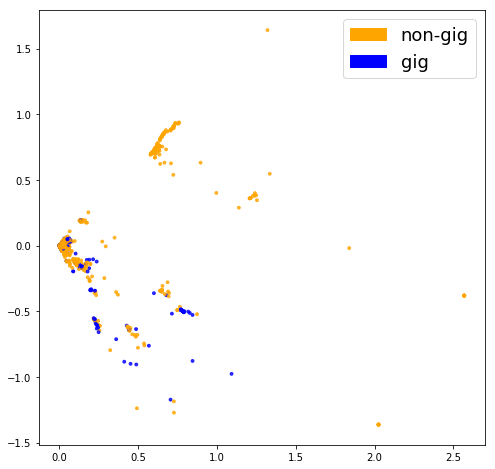

In [13]:
label_names = ['non-gig', 'gig']

fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train, label_names)
plt.show()

### Binary LSA Results

For the gig/non-gig labels we do indeed see some separation. However, while gig roles show some similarity, the non-gig roles are distributed all over the plot. There are two main takeaways here:

1. There could be roles within the 'non-gig' which are very similar to 'gig' listings
2. There is come clear clustering within the 'non-gig' class, indication that it might be interesting to further label the data to see if multi-class clustering is informative.

Last, the initial dataset contained only 1000 observsations. Let's see how we fare with more data.

## Multiclass Problem

In [4]:
df = pd.read_csv('../data/multiclass/labeled_large.csv')

# remove samples not of interest
exclude = ['crna', 'pharmacist', 'cna']
df = df[~(df.isin(exclude))]

# map roles to general labels
role_mapper = {'delivery':'driver', 
               'server':'service', 
               'product manager':'ignore', 
               'software engineer':'ignore',
               'electrical engineer':'ignore', 
               'systems engineer':'ignore', 
               'mechanical engineer':'ignore',
               'nurse':'nurse', 
               'business analyst':'ignore', 
               'cook':'service', 
               'chef':'service',
               'devops engineer':'ignore', 
               'machine learning engineer':'ignore', 
               'registered nurse':'nurse', 
               'cdl':'ignore'}

df['label'] = df['role'].map(role_mapper)

df = df[['title','label']].dropna()

df.label.value_counts()

ignore     72376
nurse      53862
service    48280
driver     22997
Name: label, dtype: int64

** Cleanup Data **

In [5]:
class_mapper = {'ignore': 0, 'nurse': 1, 'service': 2, 'driver': 3}

df = df[['title','label']].dropna()
df['label'] = df['label'].map(class_mapper)
df.rename(columns={'title':'job_title','label':'class_label'},inplace=True)
df.shape

(197515, 2)

In [6]:
df = standardize_text(df, 'job_title')

X_train, X_test, y_train, y_test = train_test_split(df['job_title'], 
                                                    df['class_label'], 
                                                    test_size=0.2, 
                                                    random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

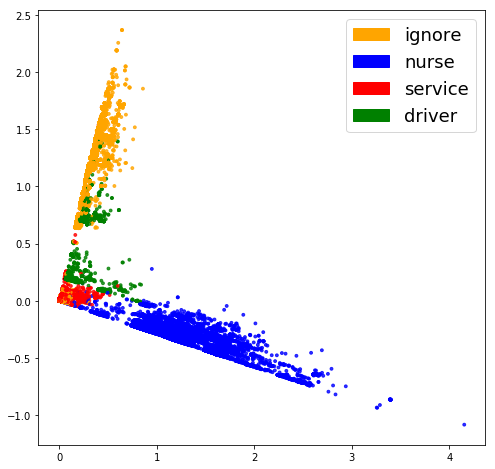

In [7]:
label_names = ['ignore', 'nurse', 'service', 'driver']

fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train, label_names)
plt.show()

### Multiclass Results

In the multiclass case, we take a dataset with nearly 200,000 observations falling within 4 class labels. These include "nursing", "service", "driver/delivery" roles, and a fourth "ignore" label for roles we are not currently interested in. These roles are typically more skilled positions, such as software or management jobs. 

In terms of sepaation, we see some interesting patterns emerge:

1. Nursing roles are clearly and distincltly separate from the rest.
2. Driver roles show two sub-clusters. This is likely due to the fact that "driver" and "shopper" jobs were both labeled within the same class, resulting in a single class with distinct clusters.
3. Skilled positions ("ignore") are separate from the other classes.
4. Service industry roles show little sprawl and are tightly clustered near the origin.

## Summary

Overall, it appears that some separation becomes apparent with sufficiently similar roles. Within the gig/non-gig case, it is difficult to draw many conclusions, as the roles within the two groups may have significant overlap, or roles within a single group might be very dissimilar. When we further break down the labels, we begin to see better grouping and separation. 